In [2]:
'import libraries of interest'
from spectral.io import envi
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity as cosineDist

from ganTraining import GANModel_1d 
from matplotlib import pyplot as plt

%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [3]:
'------------------------------------------------------------------------------------------------------'
'STEP-1: CREATE A NEURAL NETWORK MODEL FOR THE REPRESENTATION'
'------------------------------------------------------------------------------------------------------'
obj = GANModel_1d(img_rows=240, dropout=0.0, genFilters=250, disFilters=20, filterSize=11)
dis1 = obj.disModel_CV_L6s2()
'Get the pre-trained weights'
dis1.load_weights(('/Volume2/arunFiles/pythonCodeFiles/CRISM_repLearning/modelsOnYukiModel_cR_wGAN' +
                   '/Models/Model-4_small/discriminator/dis_cR_75.h5'))
disRep = obj.disModel_CV_L6s2_rep(dis1)
disRep.summary()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 120, 20)           240       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 60, 40)            8840      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 30, 80)            35280     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 15, 160)           140960    
_________________________________________________________________
flatten_2 (Flatten)          (None, 2400)              0         
Total params: 185,320
Trainable params: 185,320
Non-trainable params: 0
_________________________________________________________________


In [4]:
'------------------------------------------------------------------------------------------------------'
'STEP-2: LOAD AND NORMALIZE MICA CONTINUUM REMOVED DATA'
'------------------------------------------------------------------------------------------------------'
sliName = '/Volume1/data/CRISM/arun/UMass_redMICA_CR_enhanced_v4.sli'
sliHdrName = '/Volume1/data/CRISM/arun/UMass_redMICA_CR_enhanced_v4.sli.hdr'

'Read in the spectra'
micaSLI = envi.open(sliHdrName, sliName)
mica_dataRed = micaSLI.spectra
mica_dataRed = mica_dataRed[:, 4:244]
mica_dataRed = mica_dataRed.reshape(mica_dataRed.shape[0], mica_dataRed.shape[1], 1)

'Read in the header'
sliHdr = envi.read_envi_header(sliHdrName)
endMem_Name = sliHdr['spectra names']
wavelength = np.asarray(sliHdr['wavelength'], dtype='single')
wavelength = wavelength[4:244]

'Get the predictions at output layer for the MICA DATA'
mica_dataPreds_l2 = np.asarray(disRep.predict(mica_dataRed))

Text(0.5,1,'Non-zero filters: 221')

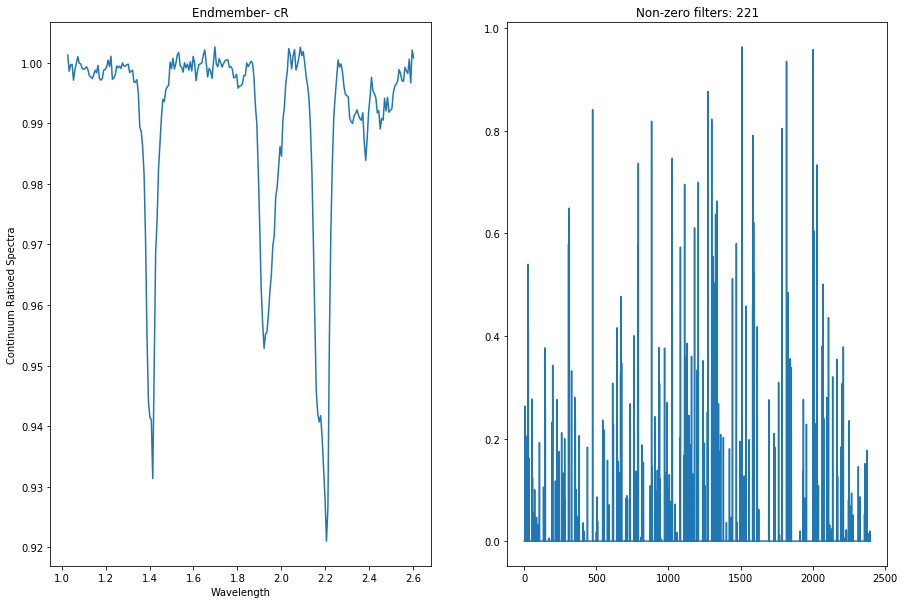

In [5]:
i = 9
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(1,2,1)
ax1.plot(wavelength, np.squeeze(mica_dataRed[i,:,:]))
plt.title('Endmember- cR')
plt.ylabel('Continuum Ratioed Spectra')
plt.xlabel('Wavelength')
ax2 = plt.subplot(1,2,2)
ax2.plot(range(2400), np.squeeze(mica_dataPreds_l2[i,:]))
nonZeroFilters_kaol = np.count_nonzero(np.squeeze(mica_dataPreds_l2[i,:]))
plt.title(('Non-zero filters: {0}'.format(nonZeroFilters_kaol)))

Text(0.5,1,'Non-zero filters: 201')

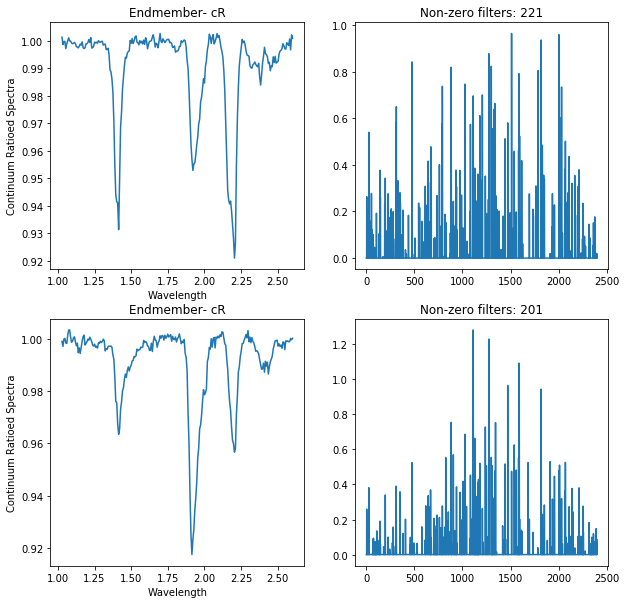

In [7]:
j = 10
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,2,1)
ax1.plot(wavelength, np.squeeze(mica_dataRed[i,:,:]))
plt.title('Endmember- cR')
plt.ylabel('Continuum Ratioed Spectra')
plt.xlabel('Wavelength')
ax2 = plt.subplot(2,2,2)
ax2.plot(range(2400), np.squeeze(mica_dataPreds_l2[i,:]))
nonZeroFilters_kaol = np.count_nonzero(np.squeeze(mica_dataPreds_l2[i,:]))
plt.title(('Non-zero filters: {0}'.format(nonZeroFilters_kaol)))
ax1 = plt.subplot(2,2,3)
ax1.plot(wavelength, np.squeeze(mica_dataRed[j,:,:]))
plt.title('Endmember- cR')
plt.ylabel('Continuum Ratioed Spectra')
plt.xlabel('Wavelength')
ax2 = plt.subplot(2,2,4)
ax2.plot(range(2400), np.squeeze(mica_dataPreds_l2[j,:]))
nonZeroFilters_alSmect = np.count_nonzero(np.squeeze(mica_dataPreds_l2[j,:]))
plt.title(('Non-zero filters: {0}'.format(nonZeroFilters_alSmect)))

Text(0.5,1,'Non-zero filters: 201')

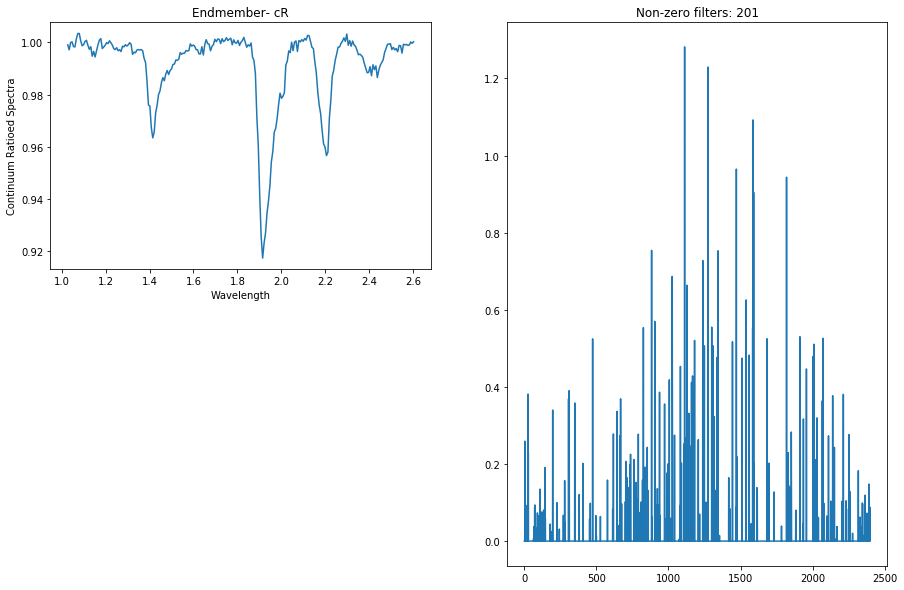

In [8]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(2,2,1)
ax1.plot(wavelength, np.squeeze(mica_dataRed[j,:,:]))
plt.title('Endmember- cR')
plt.ylabel('Continuum Ratioed Spectra')
plt.xlabel('Wavelength')
ax2 = plt.subplot(1,2,2)
ax2.plot(range(2400), np.squeeze(mica_dataPreds_l2[j,:]))
nonZeroFilters_alSmect = np.count_nonzero(np.squeeze(mica_dataPreds_l2[j,:]))
plt.title(('Non-zero filters: {0}'.format(nonZeroFilters_alSmect)))

In [ ]:
'Find the active filters in Kaolinite'
actFilt_kaol = np.nonzero(mica_dataPreds_l2[i,:])
print actFilt_kaol

In [ ]:
'Find the active filters in Al-Smect'
actFilt_alSmect = np.nonzero(mica_dataPreds_l2[j,:])
print actFilt_alSmect

In [ ]:
diff = np.setdiff1d(actFilt_kaol, actFilt_alSmect)
print (mica_dataPreds_l2[i,diff])

In [ ]:
diff1 = np.setdiff1d(actFilt_alSmect, actFilt_kaol)
print (mica_dataPreds_l2[j,diff1])

In [ ]:
t1 = cosineDist(mica_dataPreds_l2[j,:], mica_dataPreds_l2[i,:])
print t1

In [ ]:
t2 = cosineDist(mica_dataPreds_l2[1,:], mica_dataPreds_l2[i,:])
print t2

In [ ]:
distMat = np.zeros((27,27))
for ii in range(27):
    for jj in range(ii, 27):
        distMat[ii, jj] = cosineDist(np.squeeze(mica_dataPreds_l2[ii,:]), np.squeeze(mica_dataPreds_l2[jj,:]))
        distMat[jj, ii] = distMat[ii, jj]


In [ ]:
fig3= plt.figure()
idx = 19
print endMem_Name[idx]
plt.plot(range(27), np.squeeze(distMat[idx, :]))

In [ ]:
fig4= plt.figure()
plt.imshow(distMat*100)